# Auto Insurance Fraud Data Analysis

## Goal: To find out significant factors to predict insurance fraud and make a prediction models

## Hypotheses

- months_as_customer, policy-incident: Fraud might be conducted from new customers(negative correlation expected)
- policy_csl, policy_deductable, policy_annual_premium, umbrella_limit : Fraud might be conducted with high limit of coverages(& low deductible)
- insurance education level, insured occupation, insured hobbies, insured relationship: There could be demographic patterns for fraud
- incident type, collision type, incident severity, authorities contacted : accident pattern 
- total claim amount(BI, PD seperately): claims amount pattern

## Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
import statsmodels.api as sm

In [2]:
fraud = pd.read_excel("FraudDetectionData.xlsx")
fraud.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [3]:
fraud.shape

(1000, 40)

### Create a derived variable - the time difference between policy bind date and accident date

In [4]:
fraud["policy_incident"] = fraud['incident_date'] - fraud['policy_bind_date']
fraud["policy_incident"] = fraud["policy_incident"].astype('timedelta64[D]')

In [5]:
# expected correlation between predictors and response variable
fraud = fraud.drop(['policy_bind_date','policy_state','insured_zip','capital-gains','capital-loss','incident_date',\
                    'incident_city','incident_state','incident_location','auto_make','auto_model',"_c39"], axis=1)
fraud = fraud.set_index('policy_number')
fraud.columns

Index(['months_as_customer', 'age', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_year', 'fraud_reported',
       'policy_incident'],
      dtype='object')

In [6]:
fraud_numeric = fraud.select_dtypes(exclude="object")
fraud_categorical = fraud.select_dtypes(include="object")

### Missing values check

In [7]:
print(fraud.isnull().sum()[fraud.isnull().sum()>0])
for i in fraud_categorical.columns:
    print(i, fraud_categorical[i].unique())

Series([], dtype: int64)
policy_csl ['250/500' '100/300' '500/1000']
insured_sex ['MALE' 'FEMALE']
insured_education_level ['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']
insured_occupation ['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']
insured_hobbies ['sleeping' 'reading' 'board-games' 'bungie-jumping' 'base-jumping' 'golf'
 'camping' 'dancing' 'skydiving' 'movies' 'hiking' 'yachting' 'paintball'
 'chess' 'kayaking' 'polo' 'basketball' 'video-games' 'cross-fit'
 'exercise']
insured_relationship ['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']
incident_type ['Single Vehicle Collision' 'Vehicle Theft' 'Multi-vehicle Collision'
 'Parked Car']
collision_type ['Side Collision' '?' 'Rear Collision' 'Front Collision']
incident_severity ['Major Damage' 'Minor Dam

There are missing values(?) in three variables(collision_type, property_damage, police_report_available).
It seems like the information was not collected or not clear.
Let's see how many there are.

In [8]:
print(fraud['collision_type'].value_counts())
print(fraud['property_damage'].value_counts())
print(fraud['police_report_available'].value_counts())

Rear Collision     292
Side Collision     276
Front Collision    254
?                  178
Name: collision_type, dtype: int64
?      360
NO     338
YES    302
Name: property_damage, dtype: int64
NO     343
?      343
YES    314
Name: police_report_available, dtype: int64


Since the number of missing values are too many to ignore or replace and they can be informational enough in that they are missing, leave them as another group.

### Outlier check

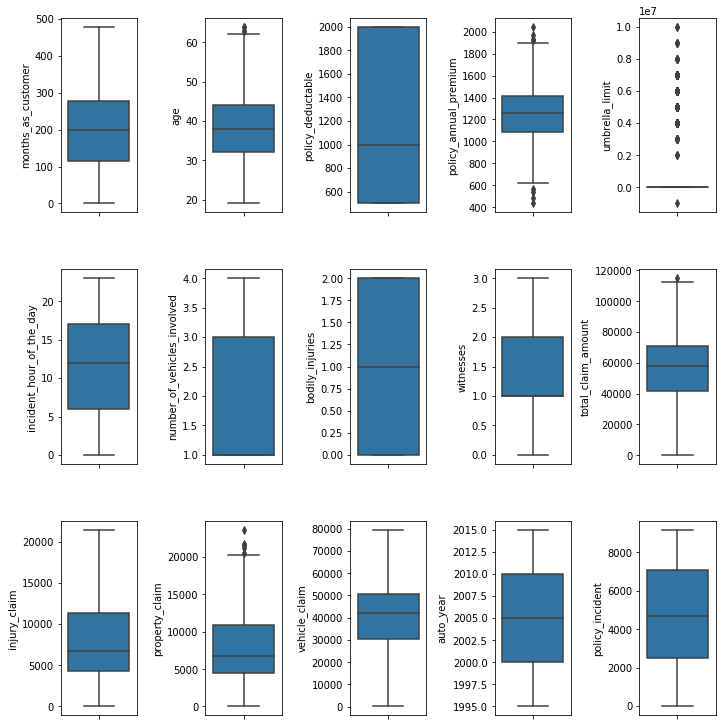

In [9]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(10, 10))
index = 0
axs = axs.flatten()
for k,v in fraud_numeric.items():
    sns.boxplot(y=k, data=fraud_numeric, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Since all values are in reasonable range, no outlier treatment is conducted.

### Exploratory Data Analysis

#### Numerical variables - boxplot, histogram

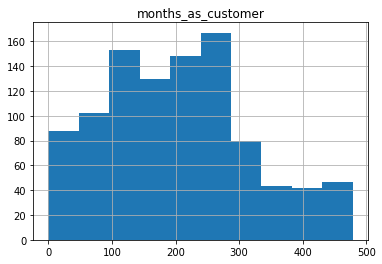

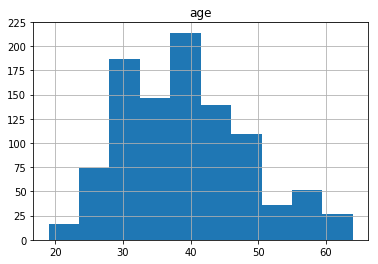

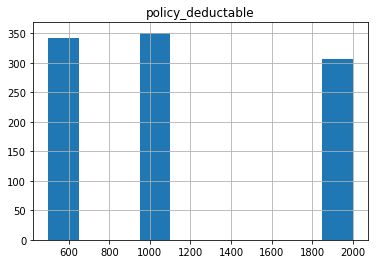

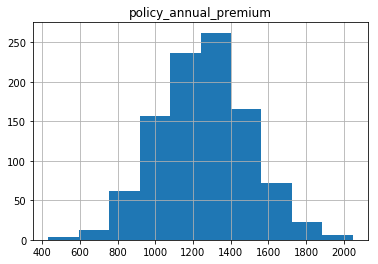

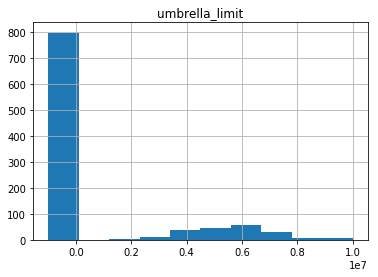

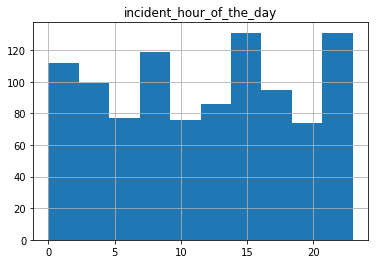

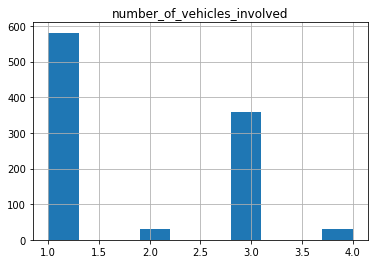

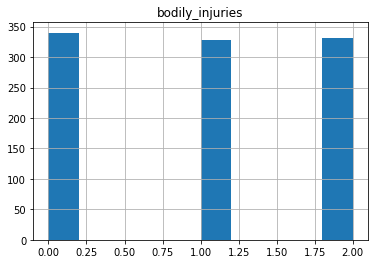

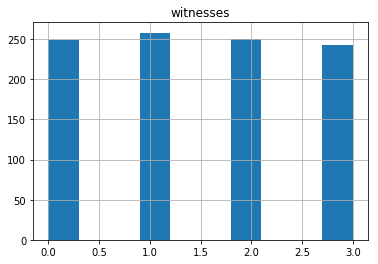

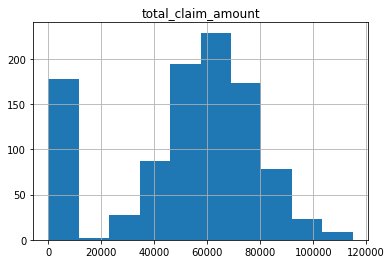

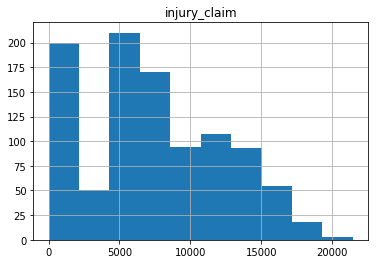

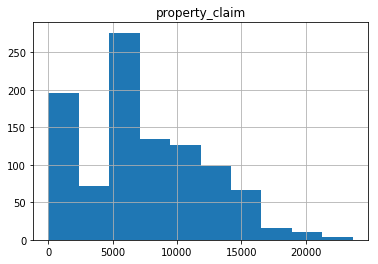

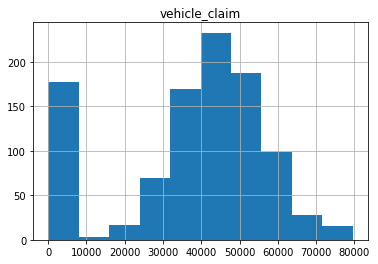

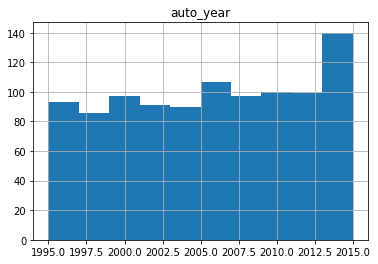

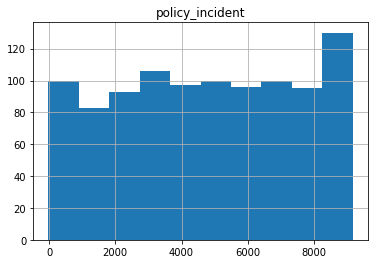

In [10]:
for i in fraud_numeric.columns:
    fraud.hist(column=i)
    plt.show()

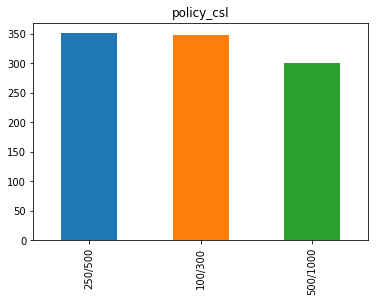

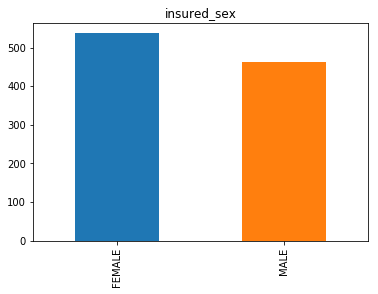

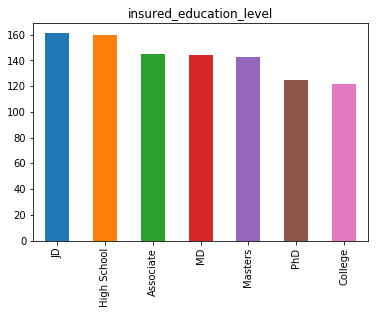

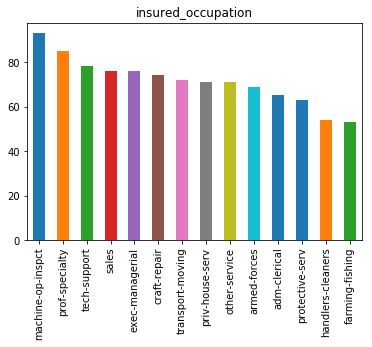

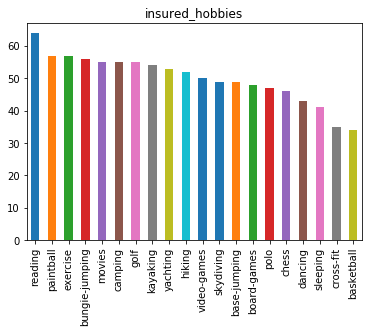

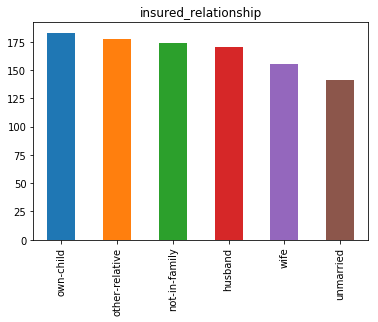

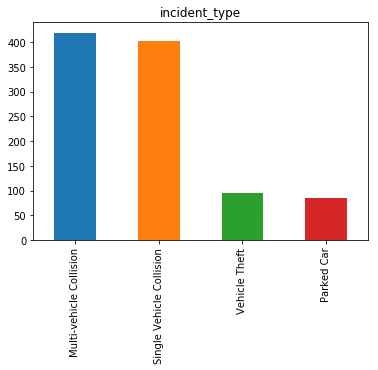

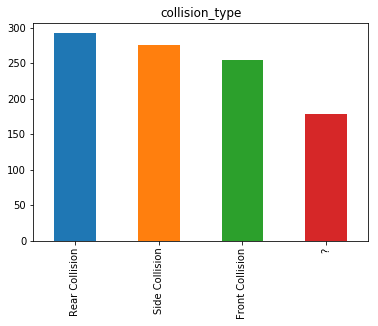

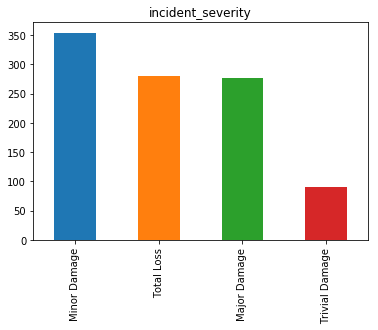

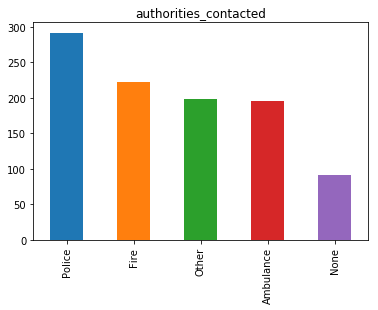

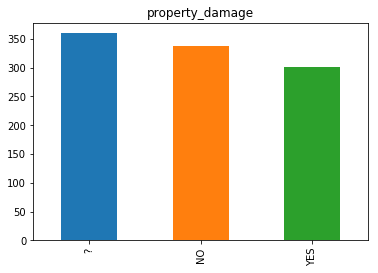

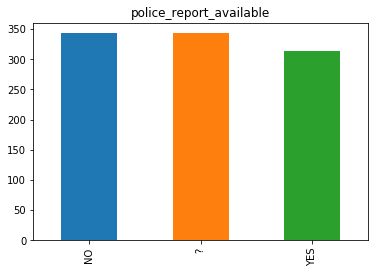

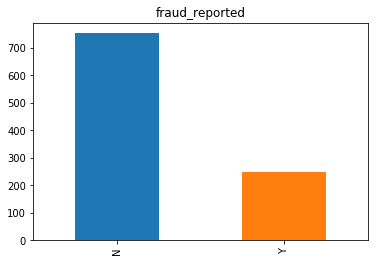

In [11]:
for i in fraud_categorical.columns:
    fraud[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

#### Difference in distribution between fraud and non-fraud

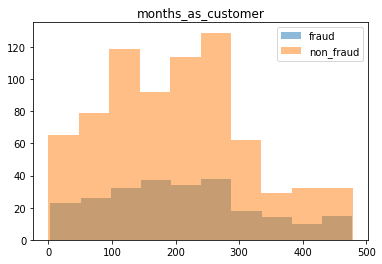

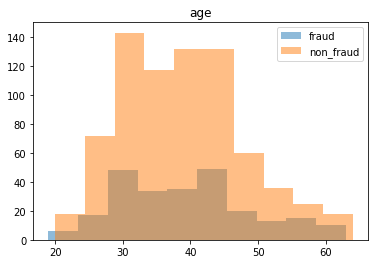

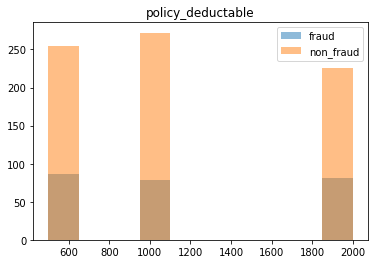

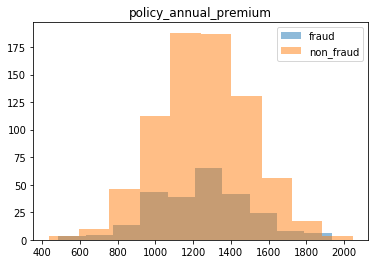

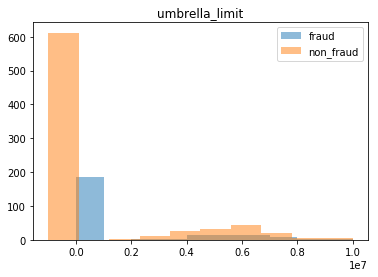

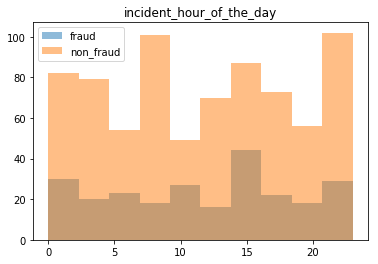

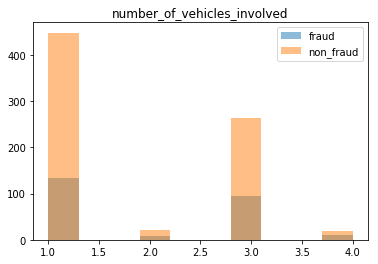

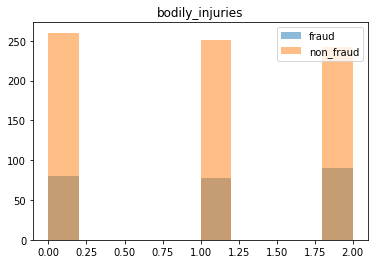

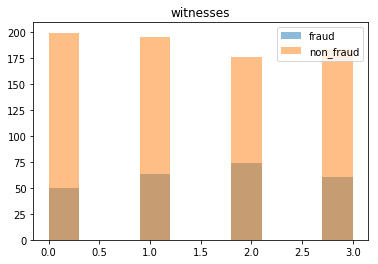

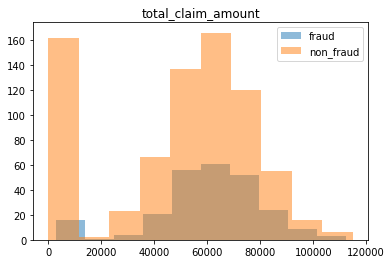

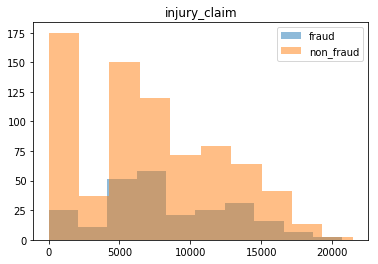

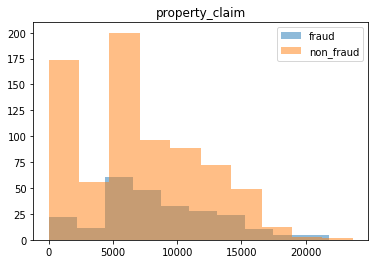

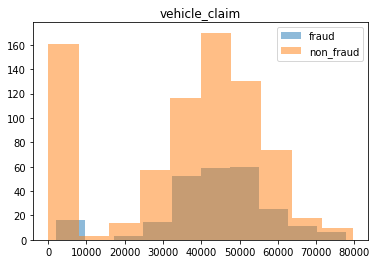

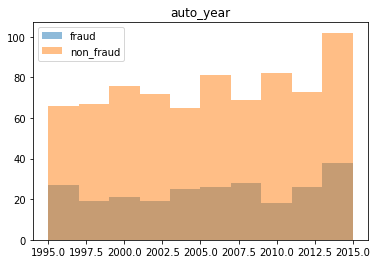

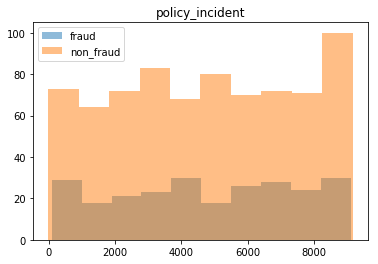

In [12]:
for i in fraud_numeric.columns:
    plt.hist(fraud[fraud["fraud_reported"]=="Y"][i],label="fraud", alpha=0.5)
    plt.hist(fraud[fraud["fraud_reported"]=="N"][i],label="non_fraud", alpha=0.5)
    plt.legend()
    plt.title(i)
    plt.show()

Histogram of all numerical variables have similar distribution between fraud and non-fraud

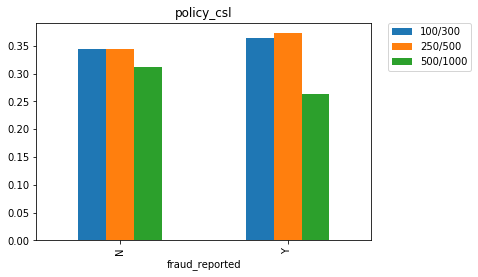

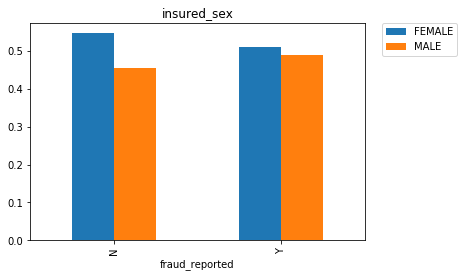

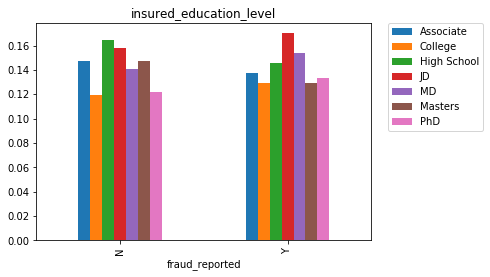

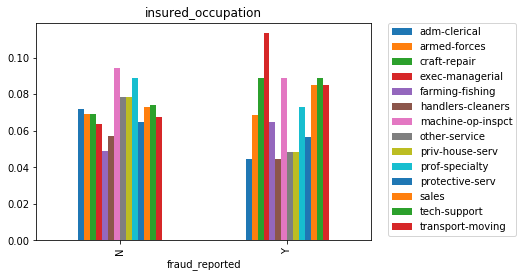

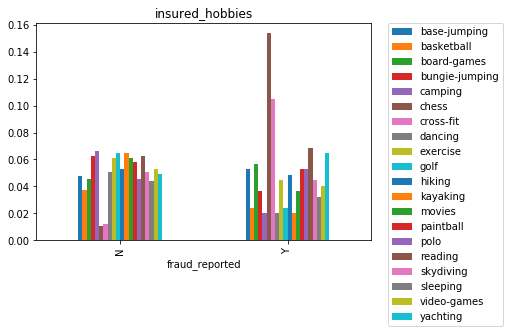

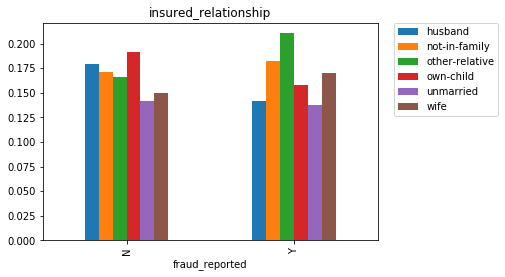

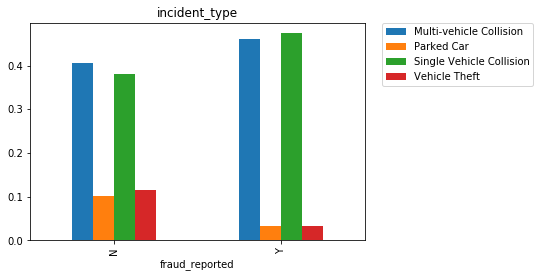

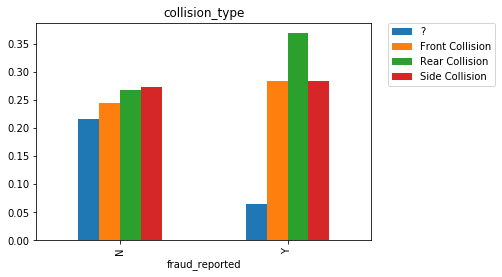

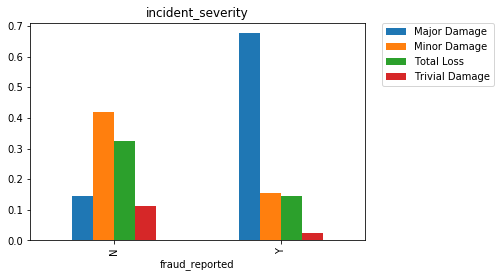

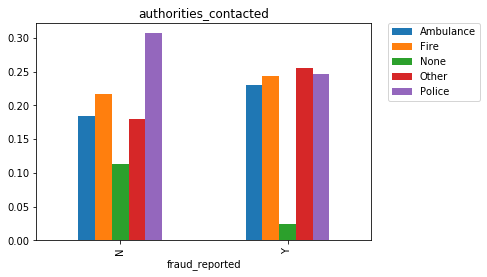

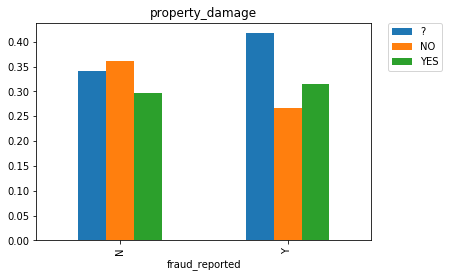

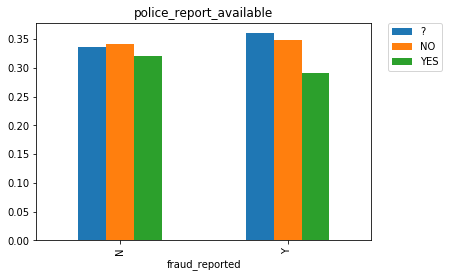

In [13]:
def bar(var):
    table = pd.crosstab(fraud[var],fraud['fraud_reported'])
    table.apply(lambda x: x/sum(x)).T.plot(kind='bar')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(i)
for i in fraud_categorical.columns[:-1]:
    bar(i)

* In terms of insured_occupation, craft-repair and exec-managerial tend to be more fraud.
* People who have hobbies of chess and cross-fit tend to be more fraud.
* Rear Collision accident tend to be more relevant to be fraud.
* Accident with fraud tend to be more severe.

In [14]:
fraud_numeric.corr()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,policy_incident
months_as_customer,1.000000,0.922098,0.026807,0.005018,0.015498,0.070639,0.014736,-0.010162,0.058383,0.062108,0.065329,0.034940,0.061013,-0.000292,0.047927
age,0.922098,1.000000,0.029188,0.014404,0.018126,0.087161,0.022102,-0.015679,0.052359,0.069863,0.075522,0.060898,0.062588,0.001354,0.036742
policy_deductable,0.026807,0.029188,1.000000,-0.003245,0.010870,0.060935,0.051214,-0.022765,0.066639,0.022839,0.039107,0.064792,0.005269,0.026105,0.050396
policy_annual_premium,0.005018,0.014404,-0.003245,1.000000,-0.006247,-0.001578,-0.045991,0.026780,0.002332,0.009094,-0.017633,-0.011654,0.020246,-0.049226,-0.001208
umbrella_limit,0.015498,0.018126,0.010870,-0.006247,1.000000,-0.023257,-0.021270,0.022743,-0.006738,-0.040344,-0.045412,-0.023790,-0.038584,0.009893,-0.046179
incident_hour_of_the_day,0.070639,0.087161,0.060935,-0.001578,-0.023257,1.000000,0.120794,-0.034563,0.006527,0.217702,0.165768,0.179536,0.215626,0.021368,-0.035873
number_of_vehicles_involved,0.014736,0.022102,0.051214,-0.045991,-0.021270,0.120794,1.000000,0.014030,-0.014669,0.274278,0.224650,0.219084,0.269393,0.034554,-0.025293
bodily_injuries,-0.010162,-0.015679,-0.022765,0.026780,0.022743,-0.034563,0.014030,1.000000,-0.005606,0.047093,0.047319,0.039749,0.043449,-0.020527,-0.028918
witnesses,0.058383,0.052359,0.066639,0.002332,-0.006738,0.006527,-0.014669,-0.005606,1.000000,-0.011114,-0.024843,0.052640,-0.022564,0.045791,-0.056577
total_claim_amount,0.062108,0.069863,0.022839,0.009094,-0.040344,0.217702,0.274278,0.047093,-0.011114,1.000000,0.805025,0.810686,0.982773,-0.035781,-0.000793


* Months as customer and age have a strong positive correlation.
* Total claim amount, injury claim, property claim and vehicle claim also have a strong positive correlation.

### Inference analysis

In [15]:
fraud['fraud_reported'].replace('Y',1,inplace=True)
fraud['fraud_reported'].replace('N',0,inplace=True)
fraud_x = fraud.drop('fraud_reported',axis=1)
fraud_y = fraud['fraud_reported']

In [16]:
for i in fraud_x.columns:
    log_model = sm.Logit.from_formula("""fraud_reported ~ """+i+""" + 1""", fraud)
    log_result = log_model.fit()
    n = 0
    for j in list(log_result.pvalues)[1:]:
        if j<0.05: n+=1
    if n>0: print(i, log_result.pvalues)

Optimization terminated successfully.
         Current function value: 0.558805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550191
         Iterations 5
insured_occupation Intercept                                  0.000002
insured_occ

* insured occupation(exec-managerial, transport-moving), insured_hobbies(camping, chess, cross-fit, kayaking), incident_type, collision_type, incident_severity, property_damage, total_claim_amount, injury_claim, property_claim, and vehicla_claim is significant with significance level of 0.05.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [18]:
fraud_x=fraud.drop(["fraud_reported"], axis=1, inplace=False)
fraud_x=pd.get_dummies(fraud_x)
fraud_y=fraud["fraud_reported"]
fraud_train_x, fraud_test_x, fraud_train_y, fraud_test_y = train_test_split(fraud_x, fraud_y, test_size=0.3, random_state=1234)

print("train data X size:",fraud_train_x.shape)
print("train data Y size:",fraud_train_y.shape)
print("test data X size:",fraud_test_x.shape)
print("test data Y size:",fraud_test_y.shape)

train data X size: (700, 90)
train data Y size: (700,)
test data X size: (300, 90)
test data Y size: (300,)


In [19]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(fraud_train_x, fraud_train_y)
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(fraud_train_x,fraud_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(fraud_test_x,fraud_test_y)))

Accuracy on training set: 0.991
Accuracy on test set: 0.810


C:\Users\yeong\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [20]:
from sklearn.ensemble import RandomForestClassifier
randomforest_classifier = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV

parameter_grid = {'n_estimators': [i for i in range(10,100,10)],
                  'criterion': ["gini","entropy"],
                  'max_depth': [i for i in range(10,100,10)],
                  'min_samples_leaf':[i for i in range(1,10,2)]}

grid_search = GridSearchCV(randomforest_classifier, param_grid = parameter_grid, n_jobs=-1)

grid_search.fit(fraud_train_x, fraud_train_y)

print ("Best Score:", grid_search.best_score_)
print ("Best params:", grid_search.best_params_)

C:\Users\yeong\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.7942857142857143
Best params: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 10}


In [21]:
rf_model = RandomForestClassifier(criterion="gini", max_depth=19, min_samples_leaf=1, n_estimators=11, random_state=111)
rf_model.fit(fraud_train_x, fraud_train_y)
print("train accuracy:",rf_model.score(fraud_train_x, fraud_train_y).round(3))
print("test accuracy:",rf_model.score(fraud_test_x, fraud_test_y).round(3))

train accuracy: 0.994
test accuracy: 0.78


In [22]:
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = fraud_x.columns
ds_feature_importance["Importance"]=rf_model.feature_importances_
ds_feature_importance.sort_values(by=['Importance'],ascending=False)

,feature,Importance
75,incident_severity_Major Damage,0.079730
46,insured_hobbies_chess,0.056165
11,property_claim,0.048541
0,months_as_customer,0.048079
3,policy_annual_premium,0.047598
9,total_claim_amount,0.046543
5,incident_hour_of_the_day,0.045530
12,vehicle_claim,0.040475
1,age,0.040238
14,policy_incident,0.039105


In [28]:
print("Accuracy", round(float(175+24)/250,4))
print("precision(Actual Y|Predict Y):", round(float(24)/29,4))
print("sensitivity or recall(Predict Y|Actual Y):", round(float(24)/61,4))

Accuracy 0.796
precision(Actual Y|Predict Y): 0.8276
sensitivity or recall(Predict Y|Actual Y): 0.3934
